<a href="https://colab.research.google.com/github/aryanntated/Sentiment_Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve
from sklearn.metrics import classification_report, plot_confusion_matrix

In [ ]:
df_train= pd.read_csv("train.txt", delimiter=";",names=['text','label'])
df_val=pd.read_csv("val.txt", delimiter=";", names=['text','label'])


In [ ]:
df=pd.concat([df_train, df_val])
df.reset_index(inplace=True, drop=True)

In [ ]:
print("Shape of the dataframe: ", df.shape)
df.sample(5)

Shape of the dataframe:  (18000, 2)


,text,label
2960,i felt rich being able to insist on paying mor...,joy
9719,i feel precious little pressure to fill them w...,joy
4186,i go fishing i really feel so carefree can i f...,joy
8965,i go back to that day however and hear jesus w...,fear
9644,im starting to feel more sociable again i actu...,joy


C:\Users\Aryann\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

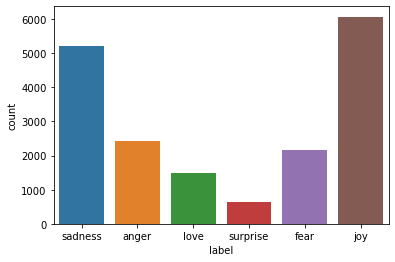

In [ ]:
sns.countplot(df.label)

In [ ]:
def custom_encoder(df):
    df.replace(to_replace="surprise", value=1, inplace=True)
    df.replace(to_replace="joy", value=1, inplace=True)
    df.replace(to_replace="love", value=1, inplace=True)
    df.replace(to_replace="fear", value=0, inplace=True)
    df.replace(to_replace="anger", value=0, inplace=True)
    df.replace(to_replace="sadness", value=0, inplace=True)

In [ ]:
custom_encoder(df['label'])

C:\Users\Aryann\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

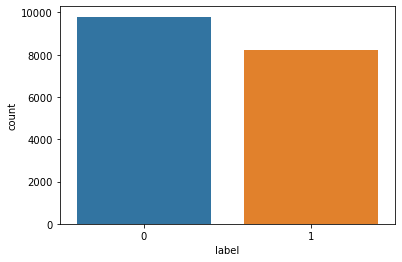

In [ ]:
sns.countplot(df.label)

In [ ]:
lm=WordNetLemmatizer()

In [ ]:
def text_transformation(df_col):
    corpus=[]
    for item in df_col:
        new_item= re.sub('[^a-zA-Z]','',str(item))
        new_item= new_item.lower()
        new_item= new_item.split()
        new_item= [lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('english'))]
        corpus.append(' '.join(str(x) for x in new_item))
    return corpus

In [ ]:
corpus=text_transformation(df['text'])

In [ ]:
corpus[:5]

['ididntfeelhumiliated',
 'icangofromfeelingsohopelesstosodamnedhopefuljustfrombeingaroundsomeonewhocaresandisawake',
 'imgrabbingaminutetopostifeelgreedywrong',
 'iameverfeelingnostalgicaboutthefireplaceiwillknowthatitisstillontheproperty',
 'iamfeelinggrouchy']

In [ ]:
cv=CountVectorizer(ngram_range=(1,2))
traindata=cv.fit_transform(corpus)
X=traindata
y=df.label

In [ ]:
parameters={#'max_features':('auto','sqrt'),
           'n_estimators':[5,10],
           'max_depth':[10,None],
           'min_samples_split':[5],
           'min_samples_leaf':[1],
           'bootstrap':[True]}

In [ ]:
grid_search= GridSearchCV (RandomForestClassifier(), parameters, cv=5, return_train_score=True, n_jobs=1)
grid_search.fit(X,y)
grid_search.best_params_

{'bootstrap': True,
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 10}

In [ ]:
for i in range(4):
    print("Parameters:", grid_search.cv_results_['params'][i])
    print("Mean Test Score:", grid_search.cv_results_['mean_test_score'][i])
    print("Rank:", grid_search.cv_results_['rank_test_score'][i])

Parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 5}
Mean Test Score: 0.5443888888888889
Rank: 4
Parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
Mean Test Score: 0.5444444444444445
Rank: 3
Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 5}
Mean Test Score: 0.5458333333333334
Rank: 2
Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
Mean Test Score: 0.5459444444444445
Rank: 1


In [ ]:
rfc= RandomForestClassifier(#max_features= grid_search.best_params_['max_features'],
                           max_depth= grid_search.best_params_['max_depth'],
                           n_estimators= grid_search.best_params_['n_estimators'],
                           min_samples_split= grid_search.best_params_['min_samples_split'],
                           min_samples_leaf= grid_search.best_params_['min_samples_leaf'],
                           bootstrap= grid_search.best_params_['bootstrap'])

rfc.fit(X,y)

RandomForestClassifier(min_samples_split=5, n_estimators=10)

In [ ]:
test_df= pd.read_csv('test.txt', delimiter=';', names=['text','label'])

In [ ]:
X_test, y_test= test_df.text, test_df.label

# encode the labels into two classes 0 and 1
test_df= custom_encoder(y_test)
# pre-processing of text
test_corpus=text_transformation(X_test)
# convert the text data into vectors
testdata=cv.transform(test_corpus)
#predict the target
predictions=rfc.predict(testdata)

In [ ]:
acc_score= accuracy_score(y_test, predictions)
pre_score= precision_score(y_test, predictions)
rec_score= recall_score(y_test, predictions)

print('Accuracy Score:', acc_score)
print('Precision Score:', pre_score)
print('Recall Score:', rec_score)

print("-"*50)
cr=classification_report(y_test, predictions)
print(cr)

Accuracy Score: 0.5435
Precision Score: 1.0
Recall Score: 0.007608695652173913
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.54      1.00      0.70      1080
           1       1.00      0.01      0.02       920

    accuracy                           0.54      2000
   macro avg       0.77      0.50      0.36      2000
weighted avg       0.75      0.54      0.39      2000



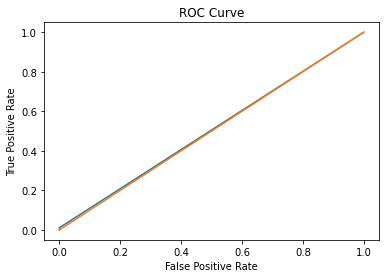

In [ ]:
prediction_probability=rfc.predict_proba(testdata)
fpr, tpr, thresholds= roc_curve(y_test, prediction_probability[:,1])
plt.plot(fpr,tpr)
plt.plot([0,1])
plt.title("ROC Curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
def expression_check(prediction_input):
    if prediction_input==0:
        print("Input Statement has negative sentiment")
    elif prediction_input==1:
        print("Input statement has positive sentiment")
    else:
        print("Invalid Statement")

In [ ]:
def sentiment_predictor(input):
    input= text_transformation(input)
    transformed_input= cv.transform(input)
    prediction=rfc.predict(transformed_input)
    expression_check(prediction)

In [ ]:
input1=["Sometimes I just don't want to go out"]
input2=["I bought a new phone and it's so good"]

In [ ]:
sentiment_predictor(input1)
sentiment_predictor(input2)

Input Statement has negative sentiment
Input Statement has negative sentiment
